In [1]:
%matplotlib inline
%qtconsole

import os
import numpy as np
import pandas

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset, date2num, num2date
from datetime import datetime, timedelta
from scipy import stats


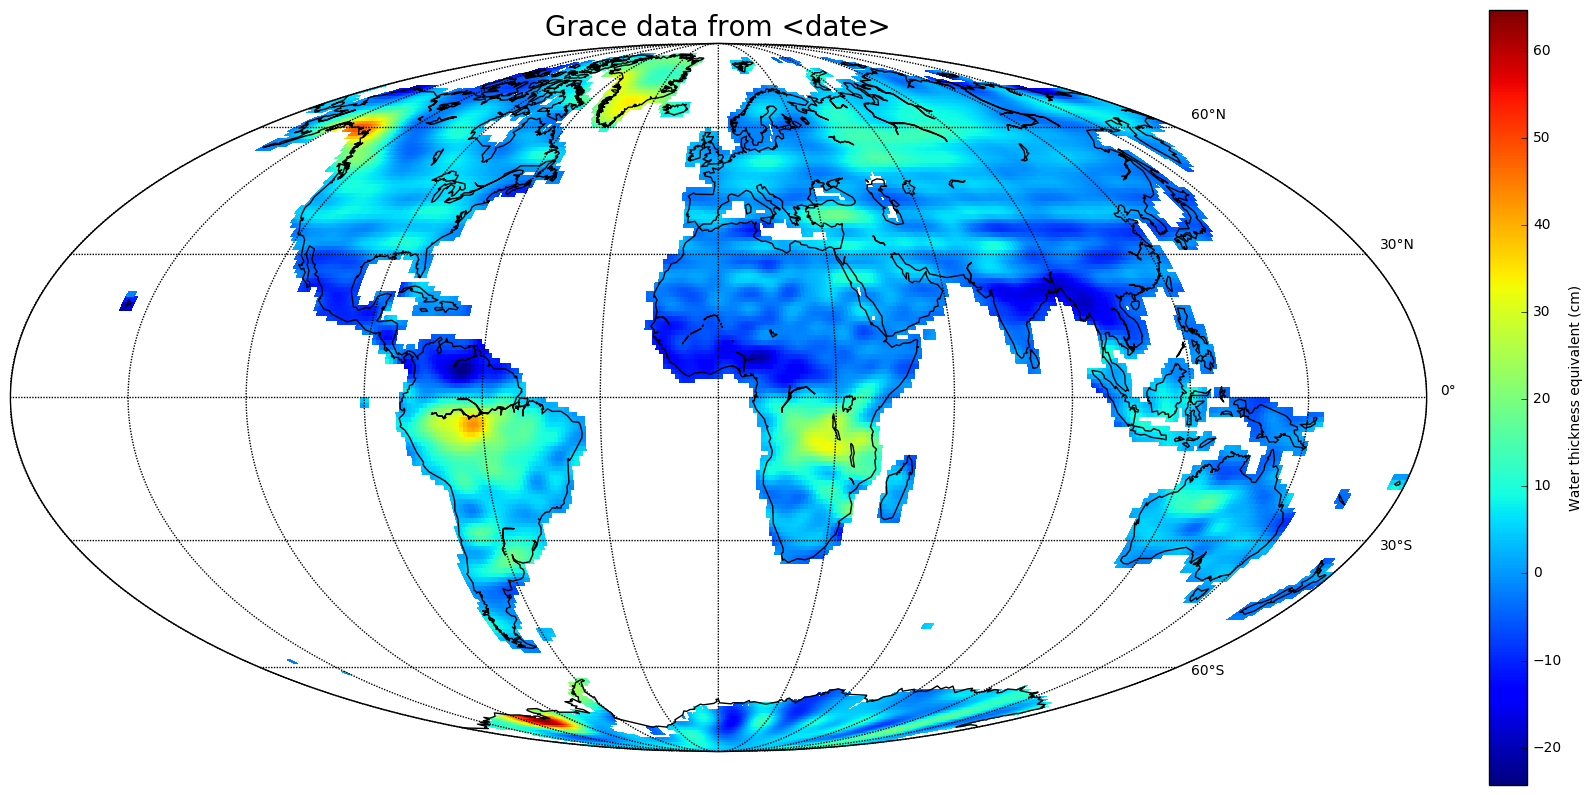

In [20]:
data = Dataset('GRCTellus.JPL.200204_201607.LND.RL05_1.DSTvSCS1411.nc')
#data = Dataset('ftp://podaac-ftp.jpl.nasa.gov/allData/tellus/L3/land_mass/RL05/netcdf/')
rmap = data['lwe_thickness'][0,:,:]
#lon_g = np.arange(-180,180)
lon_g = np.arange(0,360)
lat_g = np.arange(-90,90)

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
#m.drawmapboundary(fill_color='white')

x,y = np.meshgrid(lon_g[:], lat_g[:])

ax = plt.gca()
masked_array = np.ma.array(rmap, mask=np.isnan(rmap))
#cmap = matplotlib.m.jet
#cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,rmap,shading='flat',latlon=True);
im2 = m.pcolormesh(x,y,masked_array,shading='flat',latlon=True);
m.drawcoastlines();
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Water thickness equivalent (cm)')
plt.title('Grace data',size=20);


In [ ]:
# use pd.read_csv to read in the csv data
# Find nearest grid locations for all data